In [38]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## TCGA data

In [2]:
TCGA = pd.read_csv('TCGA_data.csv')
TCGA = TCGA.loc[(TCGA.cancer == 'BLCA') | (TCGA.cancer == 'PAAD')| (TCGA.cancer == 'KICH')| (TCGA.cancer == 'KIRC')| (TCGA.cancer == 'KIRP')]
TCGA.loc[(TCGA.cancer == 'BLCA') & (TCGA.y != 'Normal'),'y'] = 'BC'
TCGA.loc[(TCGA.cancer == 'PAAD') & (TCGA.y != 'Normal'),'y'] = 'PC'
TCGA.loc[(TCGA.cancer == 'KICH') & (TCGA.y != 'Normal'),'y'] = 'RC'
TCGA.loc[(TCGA.cancer == 'KIRC') & (TCGA.y != 'Normal'),'y'] = 'RC'
TCGA.loc[(TCGA.cancer == 'KIRP') & (TCGA.y != 'Normal'),'y'] = 'RC'

## urine data

In [4]:
BC_100 = pd.read_csv('BC_32ea_k100_cyto.csv')
Normal_100 = pd.read_csv('Normal_21ea_k100_cyto.csv')
PC_100 = pd.read_csv('PC_20ea_k100_cyto.csv')
RC_100 = pd.read_csv('RC_20ea_k100_cyto.csv')

#drop person id
BC_100.drop(['Unnamed: 0','id'], axis = 1, inplace = True)
Normal_100.drop(['Unnamed: 0','id'], axis = 1, inplace = True)
PC_100.drop(['Unnamed: 0','id'], axis = 1, inplace = True)
RC_100.drop(['Unnamed: 0','id'], axis = 1, inplace = True)

BC_100['cancer'] = 'BC'
Normal_100['cancer'] = 'normal'
PC_100['cancer'] = 'PC'
RC_100['cancer'] = "RC"

K100 = pd.concat([BC_100,Normal_100,PC_100,RC_100], axis = 0)

del [BC_100,Normal_100,PC_100,RC_100]

K100 = K100.dropna(axis=0)
K100.isna().sum().sum()

0

## 공통 col 추출

In [6]:
a = list(TCGA.columns)
b = list(K100.columns)

new_col = []
for col in a :
    for col2 in b :
        if col==col2 :
            new_col.append(col)       

In [7]:
TCGA_new = TCGA[new_col]
K100_new = K100[new_col]

In [8]:
TCGA_new.describe()

,cyto.1p36.32,cyto.1p36.31,cyto.1p36.23,cyto.1p36.22,cyto.1p36.21,cyto.1p36.13,cyto.1p36.12,cyto.1p36.11,cyto.1p35.3,cyto.1p35.2,...,cyto.9q31.3,cyto.9q32,cyto.9q33.1,cyto.9q33.2,cyto.9q33.3,cyto.9q34.11,cyto.9q34.12,cyto.9q34.13,cyto.9q34.2,cyto.9q34.3
count,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,...,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000
mean,-0.032079,-0.031753,-0.031455,-0.032120,-0.031903,-0.033995,-0.033825,-0.036324,-0.033226,-0.031052,...,-0.037264,-0.036849,-0.037645,-0.037862,-0.037204,-0.038088,-0.036377,-0.036879,-0.036091,-0.037762
std,0.141242,0.139184,0.138448,0.135821,0.139217,0.134149,0.134824,0.133454,0.132427,0.129602,...,0.156896,0.154853,0.155987,0.158991,0.155327,0.156589,0.157110,0.157137,0.158041,0.168313
min,-1.001000,-0.976300,-0.976300,-0.988600,-0.984200,-0.948200,-0.948200,-0.948200,-0.948200,-0.948200,...,-0.950700,-0.973200,-0.995200,-1.000800,-0.995200,-0.995200,-0.973200,-0.990300,-0.991400,-2.669000
25%,-0.016700,-0.017000,-0.016800,-0.016500,-0.016700,-0.016500,-0.016700,-0.017800,-0.016700,-0.014500,...,-0.028300,-0.027500,-0.027600,-0.027500,-0.027500,-0.027500,-0.026900,-0.026900,-0.025800,-0.026900
50%,0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.000800,...,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300
75%,0.005200,0.005100,0.005000,0.005000,0.004800,0.004500,0.004300,0.004100,0.004300,0.004400,...,0.004200,0.004200,0.004200,0.004300,0.004300,0.004300,0.004400,0.004500,0.004500,0.004600
max,0.868100,1.083900,0.779600,0.621700,1.362400,0.621700,0.936400,0.604900,0.963900,1.057800,...,0.602400,0.545100,0.545100,0.836500,0.545100,0.545100,1.467700,0.907600,0.782700,0.782700


In [9]:
K100_new.describe()

,cyto.1p36.32,cyto.1p36.31,cyto.1p36.23,cyto.1p36.22,cyto.1p36.21,cyto.1p36.13,cyto.1p36.12,cyto.1p36.11,cyto.1p35.3,cyto.1p35.2,...,cyto.9q31.3,cyto.9q32,cyto.9q33.1,cyto.9q33.2,cyto.9q33.3,cyto.9q34.11,cyto.9q34.12,cyto.9q34.13,cyto.9q34.2,cyto.9q34.3
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.003806,0.030503,0.019303,0.022309,0.031741,0.015246,0.012374,-0.014843,-0.006598,-0.002351,...,-0.024203,-0.077496,-0.043479,-0.047143,-0.017504,-0.008817,0.010125,-0.021967,-0.029835,-0.020170
std,0.065767,0.070057,0.072936,0.066164,0.071540,0.051715,0.049664,0.099727,0.064092,0.073753,...,0.118375,0.112341,0.129342,0.114587,0.083742,0.087054,0.127445,0.096611,0.096595,0.089733
min,-0.163538,-0.150765,-0.096350,-0.080171,-0.135120,-0.103114,-0.083588,-0.172389,-0.332750,-0.353800,...,-0.757375,-0.797393,-0.909913,-0.765303,-0.435227,-0.444300,-0.465200,-0.452895,-0.451857,-0.427387
25%,-0.043067,-0.006353,-0.026588,-0.009179,-0.011990,-0.015800,-0.017934,-0.057215,-0.037937,-0.036900,...,-0.023969,-0.093098,-0.043668,-0.052280,-0.028756,-0.010717,-0.053150,-0.048803,-0.046911,-0.031161
50%,-0.005519,0.021088,0.014350,0.012371,0.016940,0.011629,0.007235,-0.024583,-0.009225,-0.005700,...,-0.004063,-0.058536,-0.012739,-0.023182,-0.001932,0.008633,0.021200,-0.002684,-0.014071,-0.000097
75%,0.053673,0.055309,0.041325,0.043121,0.069290,0.040707,0.034904,0.007444,0.025188,0.030400,...,0.028867,-0.029991,0.013679,0.007280,0.022841,0.028567,0.114600,0.023750,0.021911,0.029621
max,0.181846,0.368471,0.390300,0.437000,0.391080,0.227943,0.253353,0.737306,0.204550,0.256150,...,0.112406,0.061821,0.081043,0.052121,0.124841,0.121733,0.230600,0.138421,0.116714,0.101452


In [24]:
t_both = pd.concat([TCGA_new.drop(['cancer'], axis=1),TCGA['y']], axis = 1)
t_both = t_both.sort_values(['y'])
t_both.head()

,cyto.1p36.32,cyto.1p36.31,cyto.1p36.23,cyto.1p36.22,cyto.1p36.21,cyto.1p36.13,cyto.1p36.12,cyto.1p36.11,cyto.1p35.3,cyto.1p35.2,...,cyto.9q32,cyto.9q33.1,cyto.9q33.2,cyto.9q33.3,cyto.9q34.11,cyto.9q34.12,cyto.9q34.13,cyto.9q34.2,cyto.9q34.3,y
0,-0.1624,-0.1624,-0.1624,-0.1624,-0.1624,-0.1624,-0.1624,-0.1624,-0.1624,-0.1624,...,-0.1732,-0.1732,-0.1732,-0.1732,-0.1732,-0.1732,-0.1732,-0.1732,-0.1732,BC
455,-0.0376,-0.0376,-0.0376,-0.0376,-0.0376,-0.0376,-0.0376,-0.0376,-0.0376,-0.0376,...,-0.0719,-0.0719,-0.0719,-0.0719,-0.0719,-0.0719,-0.0719,-0.0719,-0.0719,BC
452,0.0193,0.0193,0.0193,0.0193,0.0193,0.0193,0.0193,0.0193,0.0193,0.0193,...,-0.0797,-0.0797,-0.0797,-0.0797,-0.0797,-0.0797,-0.0797,-0.0797,0.3979,BC
450,0.3515,0.3515,0.3515,0.3515,0.3515,0.3515,0.3515,0.3515,0.3515,0.3515,...,-0.3351,-0.3351,-0.3351,-0.3351,-0.3351,-0.3351,-0.3351,-0.3351,-0.3824,BC
448,0.1611,0.1611,0.1611,0.1611,0.1611,0.1611,0.1611,0.1611,0.1611,0.1611,...,0.1777,0.1777,0.1777,0.1777,0.1777,0.1777,0.1777,0.1777,0.1777,BC


In [52]:
t_both.y.value_counts()

Normal    1403
RC         882
BC         408
PC         184
Name: y, dtype: int64

In [25]:
u_both = pd.concat([K100_new.drop(['cancer'], axis=1),K100['cancer']], axis = 1)
u_both = u_both.sort_values(['cancer'])
u_both.head()

,cyto.1p36.32,cyto.1p36.31,cyto.1p36.23,cyto.1p36.22,cyto.1p36.21,cyto.1p36.13,cyto.1p36.12,cyto.1p36.11,cyto.1p35.3,cyto.1p35.2,...,cyto.9q32,cyto.9q33.1,cyto.9q33.2,cyto.9q33.3,cyto.9q34.11,cyto.9q34.12,cyto.9q34.13,cyto.9q34.2,cyto.9q34.3,cancer
0,-0.025038,0.001059,-0.00455,0.013600,0.01136,-0.014229,-0.068324,-0.020417,-0.02185,-0.05465,...,-0.022250,0.015217,-0.044152,-0.004636,0.014333,0.0116,-0.004737,-0.019571,-0.022065,BC
31,0.026269,0.025059,0.05160,0.039886,0.04948,0.052114,0.034029,-0.061333,0.00590,0.05335,...,-0.028571,0.012761,-0.013152,0.028886,0.026233,0.0780,0.011579,0.046786,0.029645,BC
30,0.078692,-0.150765,-0.02850,0.003629,0.07332,0.016057,0.030265,-0.172389,-0.09065,0.04490,...,-0.062500,-0.019630,-0.031121,-0.065045,0.030800,0.0316,-0.088000,-0.040714,0.101452,BC
29,0.071923,0.120000,0.01965,0.023029,0.07772,-0.006800,-0.041324,-0.040278,-0.03025,0.17255,...,-0.084964,0.023935,-0.020848,0.003795,0.004633,-0.0196,-0.002842,0.045214,0.049774,BC
28,-0.062885,0.023941,0.05890,0.079000,0.07052,0.000886,0.060559,-0.006889,-0.02155,-0.03635,...,-0.007643,-0.058065,0.038818,0.008659,-0.009667,-0.0528,0.030895,-0.042143,0.008774,BC


In [54]:
u_both.cancer.value_counts()

BC        32
normal    21
PC        19
RC        16
Name: cancer, dtype: int64

## 1. scale : 기본 스케일. 평균과 표준편차 사용

In [62]:
tt_both = pd.DataFrame(scale(t_both))
uu_both = pd.DataFrame(scale(u_both))

Text(0.5,1,'RC')

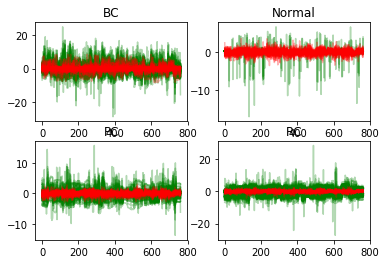

In [64]:
plt.subplot(2,2,1)
for i in range(408) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3)
plt.title('BC')

plt.subplot(2,2,2)
for i in range(408,1811) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32,53) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('Normal')

plt.subplot(2,2,3)
for i in range(1811,1995) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(53,72) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('PC')

plt.subplot(2,2,4)
for i in range(1995,2877) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(72,88) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('RC')

In [10]:
X = TCGA_new.drop(['cancer'], axis=1)
X = scale(X)
Y = TCGA['y']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.904


In [20]:
X = K100_new.drop(['cancer'], axis=1)
X = scale(X)
Y = K100['cancer']

predicted = rf.predict(X)
accuracy = accuracy_score(Y, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.352


## 2. robust_scale : 중앙값과 IQR사용. 아웃라이어의 영향을 최소화

In [65]:
tt_both = pd.DataFrame(robust_scale(t_both))
uu_both = pd.DataFrame(robust_scale(u_both))

Text(0.5,1,'RC')

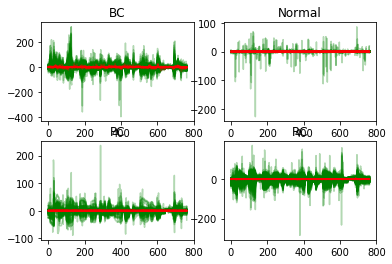

In [66]:
plt.subplot(2,2,1)
for i in range(408) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3)
plt.title('BC')

plt.subplot(2,2,2)
for i in range(408,1811) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32,53) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('Normal')

plt.subplot(2,2,3)
for i in range(1811,1995) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(53,72) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('PC')

plt.subplot(2,2,4)
for i in range(1995,2877) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(72,88) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('RC')

In [21]:
X = TCGA_new.drop(['cancer'], axis=1)
X = robust_scale(X)
Y = TCGA['y']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.911


In [22]:
X = K100_new.drop(['cancer'], axis=1)
X = robust_scale(X)
Y = K100['cancer']

predicted = rf.predict(X)
accuracy = accuracy_score(Y, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.227


## 3. minmax_scale : 최대/최소값이 각각 1, 0이 되도록 

In [76]:
tt_both = pd.DataFrame(minmax_scale(t_both))
uu_both = pd.DataFrame(minmax_scale(u_both))

Text(0.5,1,'RC')

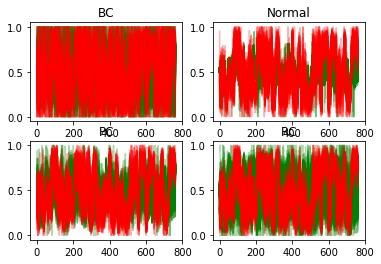

In [77]:
plt.subplot(2,2,1)
for i in range(408) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3)
plt.title('BC')

plt.subplot(2,2,2)
for i in range(408,1811) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32,53) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('Normal')

plt.subplot(2,2,3)
for i in range(1811,1995) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(53,72) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('PC')

plt.subplot(2,2,4)
for i in range(1995,2877) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(72,88) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('RC')

In [23]:
X = TCGA_new.drop(['cancer'], axis=1)
X = minmax_scale(X)
Y = TCGA['y']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.91


In [24]:
X = K100_new.drop(['cancer'], axis=1)
X = minmax_scale(X)
Y = K100['cancer']

predicted = rf.predict(X)
accuracy = accuracy_score(Y, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.284


## 4. maxabs_scale :  최대절대값과 0이 각각 1, 0이 되도록 

In [74]:
tt_both = pd.DataFrame(maxabs_scale(t_both))
uu_both = pd.DataFrame(maxabs_scale(u_both))

Text(0.5,1,'RC')

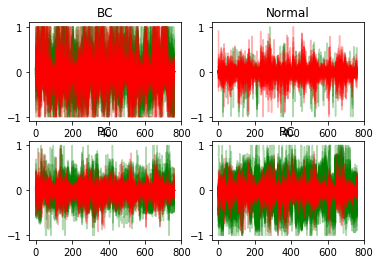

In [75]:
plt.subplot(2,2,1)
for i in range(408) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3)
plt.title('BC')

plt.subplot(2,2,2)
for i in range(408,1811) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(32,53) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('Normal')

plt.subplot(2,2,3)
for i in range(1811,1995) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(53,72) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('PC')

plt.subplot(2,2,4)
for i in range(1995,2877) :
    tt_both.iloc[i,0:762].plot(color = 'g', alpha = 0.3) 
for i in range(72,88) :
    uu_both.iloc[i,0:762].plot(color = 'r', alpha = 0.3) 
plt.title('RC')

In [25]:
X = TCGA_new.drop(['cancer'], axis=1)
X = maxabs_scale(X)
Y = TCGA['y']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.914


In [26]:
X = K100_new.drop(['cancer'], axis=1)
X = maxabs_scale(X)
Y = K100['cancer']

predicted = rf.predict(X)
accuracy = accuracy_score(Y, predicted)

print(f'accuracy score: {accuracy:.3}')

accuracy score: 0.42
